# Experimenting SHAP with multivariate sequential data, on PyTorch
---

Although SHAP works pretty great for most use cases, providing realistic and well founded interpretability to machine learning models, it doesn't seem to be able to handle multivariate sequential data. The issue appears that it doesn't successfully filter out the padding values (which are needed to form tensors when the data has variable sequence length).

This notebook serves as a simple example to illustrate and debug SHAP for this multivariate sequential data scenarios, using the PyTorch framework.

## Importing the necessary packages

In [1]:
import pandas as pd              # Pandas to handle the data in dataframes
import numpy as np               # Math operations with NumPy
import torch                     # PyTorch to create and apply deep learning models
import shap                      # Model-agnostic interpretability package inspired on Shapley values
import utils                     # Contains auxiliary functions
from Time_Series_Dataset import Time_Series_Dataset # Dataset subclass which allows the creation of Dataset objects
from NeuralNetwork import NeuralNetwork # Import the neural network model class

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-6mba8ec9 because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Debugging packages
# import pixiedust                 # Debugging in Jupyter Notebook cells
import time                      # Calculate code execution time

## Creating a dummy dataset

In [3]:
dmy_data = np.array([[0, 0, 23, 284, 70, 5, 0],
                     [0, 1, 24, 270, 73, 5, 0],
                     [0, 2, 22, 290, 71, 5, 0],
                     [0, 3, 20, 288, 65, 4, 1],
                     [0, 4, 21, 297, 64, 4, 1],
                     [1, 0, 25, 300, 76, 5, 0],
                     [1, 1, 19, 283, 70, 5, 0],
                     [1, 2, 19, 306, 59, 5, 1],
                     [1, 3, 18, 298, 55, 3, 1],
                     [2, 0, 20, 250, 70, 5, 0],
                     [2, 1, 20, 254, 68, 4, 1],
                     [2, 2, 19, 244, 70, 3, 1],
                     [3, 0, 27, 264, 78, 4, 0],
                     [3, 1, 22, 293, 67, 4, 1]])

In [4]:
dmy_df = pd.DataFrame(dmy_data, columns=['subject_id', 'ts', 'Var0', 'Var1', 'Var2', 'Var3', 'label'])
dmy_df

,subject_id,ts,Var0,Var1,Var2,Var3,label
0,0,0,23,284,70,5,0
1,0,1,24,270,73,5,0
2,0,2,22,290,71,5,0
3,0,3,20,288,65,4,1
4,0,4,21,297,64,4,1
5,1,0,25,300,76,5,0
6,1,1,19,283,70,5,0
7,1,2,19,306,59,5,1
8,1,3,18,298,55,3,1
9,2,0,20,250,70,5,0


In [5]:
# List of used features
dmy_cols = list(dmy_df.columns)

# Remove features that aren't used by the model to predict the label
for unused_feature in ['subject_id', 'ts', 'label']:
    dmy_cols.remove(unused_feature)

In [6]:
dmy_cols

['Var0', 'Var1', 'Var2', 'Var3']

## Setting up model parameters and constants

### Neural network and dataset parameters

In [7]:
n_patients = dmy_df.subject_id.nunique()     # Total number of patients
n_inputs = len(dmy_df.columns)               # Number of input features
n_hidden = 2                                 # Number of hidden units
n_outputs = 1                                # Number of outputs
n_layers = 1                                 # Number of LSTM layers
p_dropout = 0.2                              # Probability of dropout

### Training parameters

In [8]:
batch_size = 3                                  # Number of patients in a mini batch
n_epochs = 50                                   # Number of epochs
lr = 0.001                                      # Learning rate

### Sequence length dictionary

(number of temporal events) of each sequence (patient)

In [9]:
seq_len_df = dmy_df.groupby('subject_id').ts.count().to_frame().sort_values(by='ts', ascending=False)
seq_len_dict = dict([(idx, val[0]) for idx, val in list(zip(seq_len_df.index, seq_len_df.values))])

In [10]:
seq_len_dict

{0: 5, 1: 4, 2: 3, 3: 2}

## Preparing the dataset

### Normalizing the features

In [11]:
dmy_norm_df = utils.normalize_data(dmy_df, see_progress=False)
dmy_norm_df

,subject_id,ts,Var0,Var1,Var2,Var3,label
0,0,0,0.627125,0.195028,0.279553,0.862958,0
1,0,1,1.008854,-0.499982,0.768770,0.862958,0
2,0,2,0.245397,0.492890,0.442625,0.862958,0
3,0,3,-0.518060,0.393603,-0.535810,-0.479421,1
4,0,4,-0.136332,0.840395,-0.698882,-0.479421,1
5,1,0,1.390582,0.989326,1.257988,0.862958,0
6,1,1,-0.899788,0.145385,0.279553,0.862958,0
7,1,2,-0.899788,1.287188,-1.514245,0.862958,1
8,1,3,-1.281517,0.890039,-2.166534,-1.821799,1
9,2,0,-0.518060,-1.492854,0.279553,0.862958,0


### Padding

Pad the data so that all sequences have the same length (so that it can be converted to a PyTorch tensor).

In [12]:
padding_value = 999999

In [13]:
data = utils.dataframe_to_padded_tensor(dmy_norm_df, seq_len_dict, n_patients, n_inputs, padding_value=padding_value)

In [14]:
data

tensor([[[ 0.0000e+00,  0.0000e+00,  6.2713e-01,  1.9503e-01,  2.7955e-01,
           8.6296e-01,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  1.0089e+00, -4.9998e-01,  7.6877e-01,
           8.6296e-01,  0.0000e+00],
         [ 0.0000e+00,  2.0000e+00,  2.4540e-01,  4.9289e-01,  4.4263e-01,
           8.6296e-01,  0.0000e+00],
         [ 0.0000e+00,  3.0000e+00, -5.1806e-01,  3.9360e-01, -5.3581e-01,
          -4.7942e-01,  1.0000e+00],
         [ 0.0000e+00,  4.0000e+00, -1.3633e-01,  8.4040e-01, -6.9888e-01,
          -4.7942e-01,  1.0000e+00]],

        [[ 1.0000e+00,  0.0000e+00,  1.3906e+00,  9.8933e-01,  1.2580e+00,
           8.6296e-01,  0.0000e+00],
         [ 1.0000e+00,  1.0000e+00, -8.9979e-01,  1.4538e-01,  2.7955e-01,
           8.6296e-01,  0.0000e+00],
         [ 1.0000e+00,  2.0000e+00, -8.9979e-01,  1.2872e+00, -1.5142e+00,
           8.6296e-01,  1.0000e+00],
         [ 1.0000e+00,  3.0000e+00, -1.2815e+00,  8.9004e-01, -2.1665e+00,
          -1.8218e+00,  1.0

### Dataset object

In [15]:
dataset = Time_Series_Dataset(data, dmy_norm_df)

### Separating into train and validation sets

Since this notebook is only for SHAP debugging purposes, with a very small dummy dataset, we'll not be using a test set.

In [16]:
# Get the train and validation sets data loaders, which will allow loading batches
train_dataloader, val_dataloader = utils.create_train_sets(dataset, validation_ratio=0.25, batch_size=batch_size, 
                                                           get_indeces=False)

## Training the model

### Initialize model

In [17]:
# Instantiate the model (removing the two identifier columns and the labels from the input size)
model = NeuralNetwork(n_inputs-3, n_hidden, n_outputs, n_layers, p_dropout)

### Running the training process

In [18]:
model = utils.train(model, train_dataloader, val_dataloader, seq_len_dict, batch_size, n_epochs, 
                    lr, model_path='models/', padding_value=padding_value)

New minimum validation loss: inf -> 0.6576125621795654.
Saving model in models/checkpoint_24_01_2023_06_09.pth
Epoch 1: Training loss: 0.8039703369140625; Training Accuracy: 0.5; Training AUC: 0.43999999999999995;                 Validation loss: 0.6576125621795654; Validation Accuracy: 0.5; Validation AUC: 0.75
----------------------
New minimum validation loss: 0.6576125621795654 -> 0.6569268703460693.
Saving model in models/checkpoint_24_01_2023_06_09.pth
Epoch 2: Training loss: 0.7391636967658997; Training Accuracy: 0.5; Training AUC: 0.7200000000000001;                 Validation loss: 0.6569268703460693; Validation Accuracy: 0.5; Validation AUC: 0.75
----------------------
New minimum validation loss: 0.6569268703460693 -> 0.6561808586120605.
Saving model in models/checkpoint_24_01_2023_06_09.pth
Epoch 3: Training loss: 0.7900145649909973; Training Accuracy: 0.5; Training AUC: 0.48;                 Validation loss: 0.6561808586120605; Validation Accuracy: 0.5; Validation AUC: 0.7

## Interpretability / SHAP

In [19]:
# Make sure the model is in evaluation mode, with dropout turned off
model.eval()

NeuralNetwork(
  (rnn): RNN(4, 2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=2, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [20]:
features, labels = dataset.X, dataset.y

In [21]:
features, labels, x_lengths = utils.sort_by_seq_len(features, seq_len_dict, labels=labels)

In [22]:
# Create a denormalized version of the feature values so that the plots are easier to understand
test_features_denorm = utils.denormalize_data(dmy_df, features, see_progress=False)

Get an overview of the model's output for each sample:

In [23]:
ref_output = model(features[:, :, 2:].float(), x_lengths)

In [24]:
ref_output

tensor([[0.3262],
        [0.3176],
        [0.3653],
        [0.3855],
        [0.3768],
        [0.3129],
        [0.3867],
        [0.4816],
        [0.4035],
        [0.3941],
        [0.3212],
        [0.3090],
        [0.2886],
        [0.3941],
        [0.3941],
        [0.2578],
        [0.3677],
        [0.3941],
        [0.3941],
        [0.3941]], grad_fn=<SigmoidBackward0>)

In [25]:
# Remove indeces that correspond to outputs in padded data
real_idx = [idx for n_subject in range(features.shape[0])
            for idx in range(n_subject*features.shape[1], n_subject*features.shape[1]+x_lengths[n_subject])]
real_idx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 15, 16]

In [26]:
# Indeces at the end of each sequence
final_seq_idx = [n_subject*features.shape[1]+x_lengths[n_subject]-1 for n_subject in range(features.shape[0])]
final_seq_idx

[4, 8, 12, 16]

In [27]:
# Ignore outputs from padded data
ref_output = ref_output[real_idx]

In [28]:
ref_output_s = pd.Series([float(x) for x in list(ref_output.detach().numpy())])

In [29]:
# Get an overview of the important features and model output for the current patient
dmy_df.assign(output=ref_output_s)

,subject_id,ts,Var0,Var1,Var2,Var3,label,output
0,0,0,23,284,70,5,0,0.326174
1,0,1,24,270,73,5,0,0.317629
2,0,2,22,290,71,5,0,0.365344
3,0,3,20,288,65,4,1,0.385477
4,0,4,21,297,64,4,1,0.376776
5,1,0,25,300,76,5,0,0.312890
6,1,1,19,283,70,5,0,0.386722
7,1,2,19,306,59,5,1,0.481636
8,1,3,18,298,55,3,1,0.403476
9,2,0,20,250,70,5,0,0.321241


In [30]:
dmy_df.assign(output=ref_output_s).to_csv('dmy_df.csv')

### Kernel Explainer

**Attention:** If you just installed all packages in requirements.txt, you'll be using the modified Kernel Explainer in the code bellow. Run `pip install -r requirements.txt`. If `shap` is not  just `pip install -e git+https://github.com/AndreCNF/shap.git@f0777334bd82a1bacad578eaf1931c3ecbf40ec6#egg=shap`.

In [31]:
# Function that will be used in the kernel explainer, converting a dataframe object into the model's output
def f(data, hidden_state=None):
    # Make sure the data is a PyTorch tensor of type float
    data = torch.from_numpy(data).unsqueeze(0).float()
    
    # Calculate the output
    output = model(data, hidden_state=hidden_state)
    
    return output.detach().numpy()

In [32]:
outputs = f(dmy_norm_df.values[:, 2:-1])
outputs

array([[0.32617354],
       [0.317629  ],
       [0.3653442 ],
       [0.3854768 ],
       [0.3767765 ],
       [0.3139137 ],
       [0.38667402],
       [0.48162162],
       [0.40347847],
       [0.30994427],
       [0.3102777 ],
       [0.28870285],
       [0.26212314],
       [0.36742833]], dtype=float32)

In [33]:
# Using original SHAP
# explainer = shap.KernelExplainer(f, dmy_norm_df.values[:, 2:-1])
# Using modified Shap
explainer = shap.KernelExplainer(f, dmy_norm_df.values, id_col_num=0, ts_col_num=1, label_col_num=n_inputs-1,
                                 isRNN=True, model_obj=model)

100%|██████████| 5/5 [00:00<00:00, 1121.77it/s]

 80%|████████  | 4/5 [00:00<00:00, 1067.39it/s]

 60%|██████    | 3/5 [00:00<00:00, 1242.63it/s]

100%|██████████| 4/4 [00:00<00:00, 140.38it/s]


In [34]:
# Using original SHAP
# shap_values = explainer.shap_values(dmy_norm_df.values[:, 2:-1], l1_reg='aic')
# shap_values = np.array(shap_values)
# Using modified Shap
shap_values = explainer.shap_values(dmy_norm_df.values, l1_reg='aic')

100%|██████████| 5/5 [00:00<00:00, 88.71it/s]

 60%|██████    | 3/5 [00:00<00:00, 96.61it/s]

100%|██████████| 4/4 [00:00<00:00, 23.11it/s]


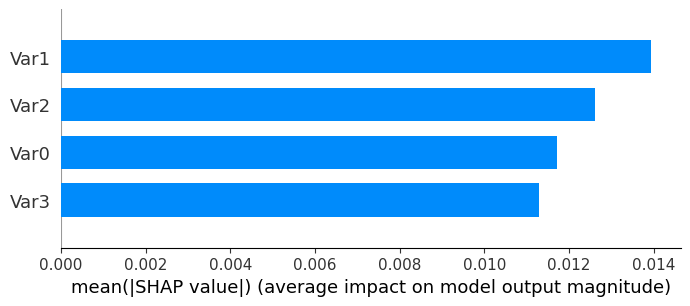

In [35]:
# Summarize the effects of all the features
shap.summary_plot(shap_values.reshape(-1, model.rnn.input_size), features=test_features_denorm[:, :, 2:].contiguous().view(-1, model.rnn.input_size).numpy(), feature_names=dmy_cols, plot_type='bar')

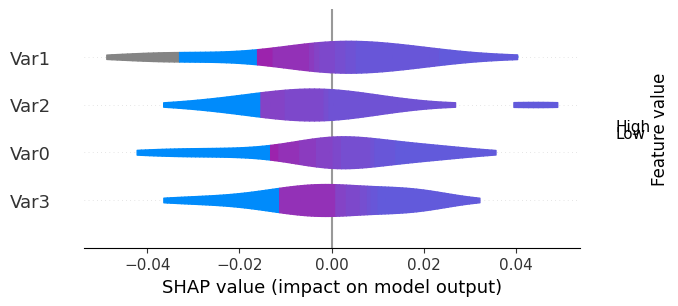

In [36]:
# Doesn't work on the original SHAP
# Summarize the effects of all the features
shap.summary_plot(shap_values.reshape(-1, model.rnn.input_size), features=test_features_denorm[:, :, 2:].contiguous().view(-1, model.rnn.input_size).numpy(), feature_names=dmy_cols, plot_type='violin')

In [37]:
# Init the JS visualization code
shap.initjs()

# Choosing which example to use
subject = 0

# True sequence length of the current patient's data
seq_len = seq_len_dict[features[subject, 0, 0].item()]

# Plot the explanation of the predictions for one subject
shap.force_plot(explainer.expected_value[0], shap_values[subject, :seq_len], features=test_features_denorm[subject, :seq_len, 2:].numpy(), feature_names=dmy_cols)

In [38]:
ref_output = model(features[subject, :, 2:].float().unsqueeze(0), [x_lengths[subject]])

In [39]:
ref_output_s = pd.Series([float(x) for x in list(ref_output.detach().numpy())])

In [40]:
# Using original SHAP
# shap_output = np.sum(shap_values, axis=2) + explainer.expected_value[0]
# shap_output = shap_output.squeeze()
# Using modified Shap
shap_output = np.sum(shap_values, axis=2) + explainer.expected_value[0]
shap_output = shap_output.flatten()

In [41]:
shap_output_s = pd.Series(shap_output)

In [42]:
# Get an overview of the important features and model output for the current patient
dmy_df[dmy_df.subject_id == subject].reset_index().drop(columns='index').assign(real_output=ref_output_s) \
                                                                        .assign(shap_output=shap_output_s)

,subject_id,ts,Var0,Var1,Var2,Var3,label,real_output,shap_output
0,0,0,23,284,70,5,0,0.326174,0.326174
1,0,1,24,270,73,5,0,0.317629,0.317629
2,0,2,22,290,71,5,0,0.365344,0.365344
3,0,3,20,288,65,4,1,0.385477,0.385477
4,0,4,21,297,64,4,1,0.376776,0.376776


In [43]:
# Get an overview of the important features and model output for the current patient
dmy_df[dmy_df.subject_id == subject].reset_index().drop(columns='index').assign(real_output=ref_output_s) \
                                                                        .assign(shap_output=shap_output_s)[['real_output', 'shap_output']].to_csv('dmy_df_realvsshapoutput_mod.csv')



In [44]:
# Init the JS visualization code
shap.initjs()

# Choosing which example to use
ts = 3

# Plot the explanation of the predictions for one subject
shap.force_plot(explainer.expected_value[0], shap_values[subject, ts], features=test_features_denorm[subject, ts, 2:].numpy(), feature_names=dmy_cols)

Finally, **the modified kernel explainer seems to calculate the features' contributions accurately**. Now, the sum of the features contributions add up correctly to the output values.

### Kernel Explainer with single reference zeros

Using just a single background sample of all zeroes. Considering how the data was normalized into z-scores, the value zero represents a feature's average value.

In [45]:
# Using original SHAP
# explainer = shap.KernelExplainer(f, np.zeros((1, n_inputs)))
# Using modified Shap
explainer = shap.KernelExplainer(f, np.zeros((1, n_inputs)), id_col_num=0, ts_col_num=1, label_col_num=n_inputs-1,
                                 isRNN=True, model_obj=model)

100%|██████████| 1/1 [00:00<00:00, 180.29it/s]


In [46]:
# Using original SHAP
# shap_values = explainer.shap_values(dmy_norm_df.values[:, 2:-1], l1_reg='aic')
# shap_values = np.array(shap_values)
# Using modified Shap
shap_values = explainer.shap_values(dmy_norm_df.values, l1_reg='aic')

100%|██████████| 5/5 [00:00<00:00, 157.83it/s]

 80%|████████  | 4/5 [00:00<00:00, 162.04it/s]

 60%|██████    | 3/5 [00:00<00:00, 161.22it/s]

100%|██████████| 4/4 [00:00<00:00, 35.89it/s]


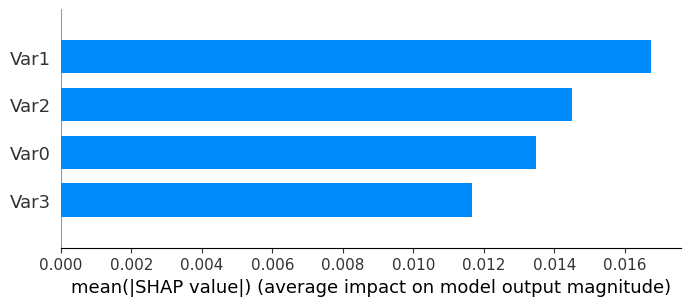

In [47]:
# Summarize the effects of all the features
shap.summary_plot(shap_values.reshape(-1, model.rnn.input_size), features=test_features_denorm[:, :, 2:].contiguous().view(-1, model.rnn.input_size).numpy(), feature_names=dmy_cols, plot_type='bar')

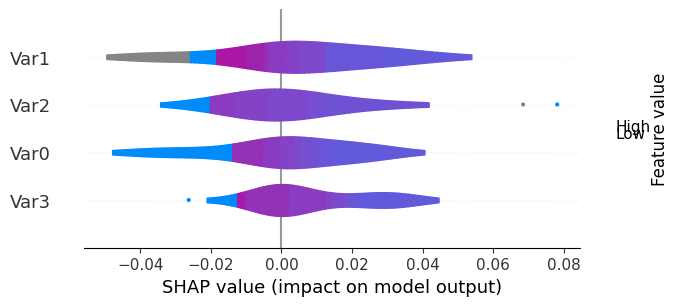

In [48]:
# Summarize the effects of all the features
shap.summary_plot(shap_values.reshape(-1, model.rnn.input_size), features=test_features_denorm[:, :, 2:].contiguous().view(-1, model.rnn.input_size).numpy(), feature_names=dmy_cols, plot_type='violin')

In [49]:
# Init the JS visualization code
shap.initjs()

# Choosing which example to use
subject = 0

# True sequence length of the current patient's data
seq_len = seq_len_dict[features[subject, 0, 0].item()]

# Plot the explanation of the predictions for one subject
shap.force_plot(explainer.expected_value[0], shap_values[subject, :seq_len], features=test_features_denorm[subject, :seq_len, 2:].numpy(), feature_names=dmy_cols)

In [50]:
ref_output = model(features[subject, :, 2:].float().unsqueeze(0), [x_lengths[subject]])

In [51]:
ref_output_s = pd.Series([float(x) for x in list(ref_output.detach().numpy())])

In [52]:
# Using original SHAP
# shap_output = np.sum(shap_values, axis=2) + explainer.expected_value[0]
# shap_output = shap_output.squeeze()
# Using modified Shap
shap_output = np.sum(shap_values, axis=2) + explainer.expected_value[0]
shap_output = shap_output.flatten()

In [53]:
shap_output_s = pd.Series(shap_output)

In [54]:
# Get an overview of the important features and model output for the current patient
dmy_df[dmy_df.subject_id == subject].reset_index().drop(columns='index').assign(real_output=ref_output_s) \
                                                                        .assign(shap_output=shap_output_s)

,subject_id,ts,Var0,Var1,Var2,Var3,label,real_output,shap_output
0,0,0,23,284,70,5,0,0.326174,0.326174
1,0,1,24,270,73,5,0,0.317629,0.317629
2,0,2,22,290,71,5,0,0.365344,0.365344
3,0,3,20,288,65,4,1,0.385477,0.385477
4,0,4,21,297,64,4,1,0.376776,0.376776


In [55]:
# Init the JS visualization code
shap.initjs()

# Choosing which example to use
ts = 3

# Plot the explanation of the predictions for one subject
shap.force_plot(explainer.expected_value[0], shap_values[subject, ts], features=test_features_denorm[subject, ts, 2:].numpy(), feature_names=dmy_cols)

**Using a single all zeroes background sample led to similar results** to the case of using all the dataset as background data! There is a small difference in the ranking of feature importance, with `Var3` slightly surpassing `Var2` as the most relevant feature and a bigger importance given to `Var1`, although it's still the least relevant. Beyond the fact that there is this small difference, it's actually interesting since I intended to have `Var3` as being the most important feature.